In [ ]:
"""
Here's a complete Python script to process Zachary's Karate Club dataset (provided as an edge list) using PyTorch Geometric (PyG)
We will train a Node2Vec model, and evaluate it:

* Zachary's Karate Club dataset is represented as an edge list with a shape of [78, 2].
* 78 edges (rows) and 2 columns (source node, target node)
* Each row denotes a connection between two nodes."
* When loaded into PyTorch Geometric, the original [78, 2] edge list is transposed to [2, 78] to match the expected input format.
"""

In [1]:
# import necessary libraries.
import torch
import numpy as np
from torch_geometric.data import Data                  # Container for graph data (nodes, edges, features).
from torch_geometric.nn import Node2Vec                # Implements the Node2Vec algorithm for embedding nodes.
from sklearn.linear_model import LogisticRegression    # Simple classifier for downstream node classification.
from sklearn.metrics import accuracy_score             # Model evaluation metric.
from sklearn.metrics import classification_report      # Model evaluation metric.
from sklearn.model_selection import train_test_split   # Splits data into train/test sets.
import matplotlib.pyplot as plt                        # Visualization
from sklearn.decomposition import PCA                  # Visualization

In [2]:
# 1. Upload and preprocess data
# We define a function to load the dataset.

def load_my_dataset(filepath):

    # 1. Create edge list according to the PyG Format.
    edges = []
    with open(file_path, 'r') as f:
        for line in f:
            if line.strip():  # Skip empty lines
                u, v = map(int, line.strip().split())
                edges.append((u-1, v-1))  # Convert to 0-based indexing

    """
        * Input: List of Edges
          edges = [(0, 1), (0, 2), (1, 2), ...]  # Example: Your Zachary's Karate Club data

        * At first we convert them to PyTorch Tensor: Creates a tensor of shape [num_edges, 2]:

        * Secondly, We transpose them for PyG Format with .t() function
          Transposes the tensor to shape [2, num_edges] (PyG's expected format):
          tensor([[0, 0, 1, ...],  # Source nodes
                 [1, 2, 2, ...]]) # Target nodes

        * Ensure Memory Layout
          Guarantees the tensor is stored in contiguous memory.
          PyG operations (e.g., message passing) require this for efficiency.
          Not strictly necessary here but good practice.

        * Output: edge_index
          Final shape: [2, num_edges]
          Example for Zachary's Karate Club (34 nodes, 78 edges):

    """
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    num_nodes = edge_index.max().item() + 1

    print(f" Shape of edges index is: {edge_index.shape}")
    print(f"Number of nodes is: {num_nodes}")

    # 2.Calculate Degrees
    """
       * For each edge (u, v), increment the degree count for both nodes.
         Example: if edges are [(0,1), (0,2)], degrees become:
           - Node 0: 2 (connected to 1 and 2) 
           - Node 1: 1 (connected to 0)  
           - Node 2: 1 (connected to 0)  

        * Reshape for PyG Compatibility
          Converts the 1D degree tensor into a 2D tensor of shape [num_nodes, 1].
          PyG expects node features in the shape [num_nodes, num_features]. 
          Here, we have 1 feature per node (degree), so we add a dummy dimension with .view(-1, 1).
          Equivalent to: x = degrees.unsqueeze(1).

        * Output Example
          For Zachary's Karate Club (34 nodes): torch.Size([34, 1])
    """
    degrees = torch.zeros(num_nodes, dtype=torch.float)
    for u, v in edges:
        degrees[u] += 1
        degrees[v] += 1
    x = degrees.view(-1, 1)  # Node features: degree

    print(f"We have one feature (degree) and its shape for 34 vertexes of dataset is: {x.shape}")    # torch.Size([34, 1])
    print("\n Tope first features of the network: ", x[:5])      # Example degrees for first 5 nodes:


    # 3. Labels: Binary (0 or 1) indicating faction membership.
    """
       * Ground Truth: After a conflict, the club split into two factions:
         - Faction 1: Led by instructor (Node 0)
         - Faction 2: Led by administrator (Node 33)
       * Labels: Binary (0 or 1) indicating faction membership.
    """

    # Synthetic labels (community detection - same as original Zachary study)
    # We know this labels
    y = torch.tensor([0 if i in {0,1,2,3,7,11,12,13,17,19,21} else 1 for i in range(num_nodes)])
    print(f"Lables shape is: {y.shape}")

    # 4. Data: Data Object Overview
    """
        * The Data class from PyTorch Geometric is a container for storing:
          - Node features (x)
          - Graph connectivity (edge_index)
          - Node labels (y)
          - (Optional) Additional attributes like edge features or masks.
       
    """
    return Data(x=x, edge_index=edge_index, y=y)


# Call the load_my_dataset function to load our dataset
file_path = 'C:/Users/Majid/Downloads/CNN/zachary-34-78'
data = load_my_dataset(file_path)

 Shape of edges index is: torch.Size([2, 78])
Number of nodes is: 34
We have one feature (degree) and its shape for 34 vertexes of dataset is: torch.Size([34, 1])

 Tope first features of the network:  tensor([[16.],
        [ 9.],
        [10.],
        [ 6.],
        [ 3.]])
Lables shape is: torch.Size([34])


In [3]:
"""
    * Creates binary masks to specify which nodes are:
       - True: Included in the training/test set
       - False: Excluded from the set
    * PyG models automatically use these masks during training/evaluation
    * This code performs a stratified train-test split for node classification tasks in PyTorch Geometric (PyG).
"""

# 2. Train-Test Split
# Generates an array of indices [0, 1, 2, ..., num_nodes-1] representing all nodes in the graph.
indices = np.arange(data.num_nodes)

# test_size=0.2: 20% of nodes will be test set, 80% training
# stratify=data.y.numpy(): Ensures both sets maintain the same class distribution as original data.
# random_state=42: Makes the split reproducible
# train_mask: Array of indices for training nodes
# test_mask: Array of indices for test nodes
#random_state=42: Makes the split reproducible
train_mask, test_mask = train_test_split(
    indices, test_size=0.2, 
    stratify=data.y.numpy(), 
    random_state=42
)

print(f"5 top Train masks are: {train_mask[:5]}")
print(f"5 top Test masks are: {test_mask[:5]}")

"""
   Initializes all-False tensors of length num_nodes
   Sets positions to True for nodes in each split:
   
   Example for 5 nodes:
       train_mask indices = [0, 2, 4]
       test_mask indices = [1, 3]
   Result:
       data.train_mask = [True, False, True, False, True]
       data.test_mask = [False, True, False, True, False]
"""
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[train_mask] = True
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask[test_mask] = True

print("\nTop 5 mask of train data and test data:")
print(data.train_mask[:5])
print(data.test_mask[:5])

5 top Train masks are: [24  7 11  4  1]
5 top Test masks are: [15  8 12  6  3]

Top 5 mask of train data and test data:
tensor([ True,  True,  True, False,  True])
tensor([False, False, False,  True, False])


In [4]:
# 3. Model Creation

# Detects if a CUDA-enabled GPU is available. Uses GPU ('cuda') if available (faster training)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Node2Vec(
    edge_index=data.edge_index,  # Graph structure
    embedding_dim=128,           # Size of node embeddings
    walk_length=20,              # Steps per random walk
    context_size=10,             # Skip-gram window size
    walks_per_node=10,           # Walks per node
    p=1.0, q=1.0,                # Walk bias parameters. p=q=1.0 gives balanced BFS/DFS behavior
    sparse=True                  # Memory optimization
).to(device)                     # Moves all model parameters to the specified device

In [5]:
# 4. Model Training
"""
   * Creates batches of random walks for efficient training
     - batch_size:	Number of walk samples per batch
     - shuffle:	Whether to shuffle walks between epochs
    * Output: 
     - pos_rw: Positive walk samples (node pairs that co-occur in walks)
     - neg_rw: Negative samples (random node pairs that don't co-occur)
"""
loader = model.loader(batch_size=128, shuffle=True)

"""
   * Why SparseAdam?
     - Memory efficient:	Optimized for sparse embeddings (like Node2Vec's)
     - Good defaults:	Works well without extensive tuning
     - Good defaults	Works well without extensive tuning
     
   * model.parameters():	All trainable embedding weights
   * lr=0.01:	Learning rate (step size)
"""
optimizer = torch.optim.SparseAdam(model.parameters(), lr=0.01)

def train():
    model.train()                                               # Switches the model to training mode
    total_loss = 0                                              # Initialize loss accumulator
    for pos_rw, neg_rw in loader:                               # Get batches of positive/negative walks
        optimizer.zero_grad()                                   # Clear previous gradients
        loss = model.loss(pos_rw.to(device), neg_rw.to(device)) # Skip-gram loss (Calculate loss)
        loss.backward()                                         # Backpropagate gradients
        optimizer.step()                                        # Update model parameters
        total_loss += loss.item()                               # Add batch loss to total
    return total_loss / len(loader)                             # Return Average Loss

# Trains the model for 100 epochs (complete passes through the data).
for epoch in range(1, 101):
    loss = train()                                      # Calls the train() function for each epoch and records the average loss.
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')  # Logs the epoch number and loss (e.g., Epoch: 05, Loss: 2.1234).

Epoch: 010, Loss: 5.0772
Epoch: 020, Loss: 3.9658
Epoch: 030, Loss: 3.3316
Epoch: 040, Loss: 3.3055
Epoch: 050, Loss: 3.1349
Epoch: 060, Loss: 3.1917
Epoch: 070, Loss: 3.0946
Epoch: 080, Loss: 3.1307
Epoch: 090, Loss: 3.1541
Epoch: 100, Loss: 3.2694


In [6]:
# 5. Generate Embeddings
model.eval()
embeddings = model().detach().cpu().numpy()  # Get embeddings (shape: [num_nodes, 128])

print(embeddings.shape)  # Output: (34, 128)
print(embeddings.dtype)  # Output: float32

(34, 128)
float32


In [7]:
# 6. Node Classification (Use embeddings as features for node classification)
train_mask = data.train_mask.cpu().numpy()  # Convert to NumPy array on CPU for train mask
test_mask = data.test_mask.cpu().numpy()    # Convert to NumPy array on CPU for test mask
clf = LogisticRegression()                 # Simple classifier
clf.fit(embeddings[train_mask], data.y.cpu().numpy()[train_mask])  # Train on embeddings
preds = clf.predict(embeddings[test_mask])  # Predict labels for test nodes
true_labels = data.y.cpu().numpy()[test_mask]   # Ground-truth test labels
print(f"The total number of labels that the data set has is: {len(set(data.y.cpu().numpy()))}") # Number of labels in dataset

The total number of labels that the data set has is: 2


In [8]:
# 7. Evaluation (Accuracy of predicted node labels vs. ground truth)
accuracy = accuracy_score(true_labels, preds)
print(f'Test Accuracy: {accuracy:.4f}')  # e.g., 0.7520

print("Classification Report:")
print(classification_report(true_labels, preds))

Test Accuracy: 0.7143
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.71      1.00      0.83         5

    accuracy                           0.71         7
   macro avg       0.36      0.50      0.42         7
weighted avg       0.51      0.71      0.60         7



C:\Users\Majid\anaconda3\envs\graph_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Majid\anaconda3\envs\graph_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Majid\anaconda3\envs\graph_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

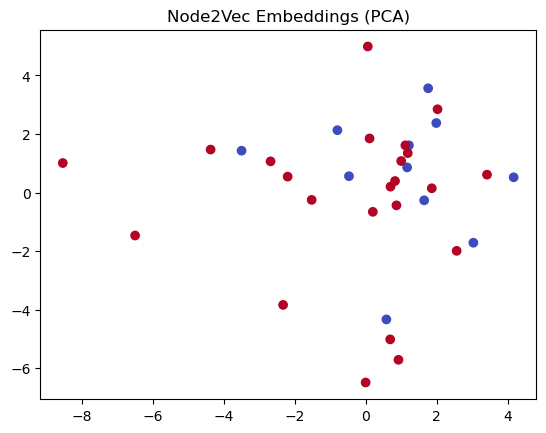

In [9]:
# 8. Visualization (Optional)

pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)  # Reduce to 2D for plotting

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=data.y.cpu().numpy(), cmap='coolwarm')
plt.title('Node2Vec Embeddings (PCA)')
plt.show()